In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import time, os
import pickle
from collections import Counter
import re
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from src.features.nlp_utilities import load_clean_nlp, spacy_tagging_demo, new_stop_words
from src.features.nlp_utilities import text_process,display_topics,count_vectorizer_display, tfidf_vectorizer_display
from src.features.nlp_utilities import tsne_viz, pca_viz, get_recommends


In [32]:
raw_data_dir = "data/raw/"
interim_data_dir= "/data/interim/"
processed_data_dir = "data/processed/"

# Data Science Topic Modeling and Job Recommender

## Introduction

The term "Data Science" has come to be a catch-all for many different speciliazations that deal with data, from data analysts to machine learning engineers. Often times, just looking at the title of role is not sufficient to figure out what kind of skills/comeptencies the role requires.

This project will attempt to topic model data science job listings scraped from Indeed.com into more useful categories, and then build a recomendation engine.

## Web Scraping

Please see the main webscraping script and scraping function imports [here](https://github.com/pdekhman/data-science-job-recommender/blob/master/src/scrape_main.py)

## Cleaning and Transforming Data

The scraped data was mostly clean. The only preprocessing was creating a dataframe and changing a few company names.

Please see [here](https://github.com/pdekhman/data-science-job-recommender/blob/master/src/features/nlp_utilities.py) for custom preprocessing and nlp functions

In [33]:
nlp_df = load_clean_nlp(raw_data_dir,"listings_final.pkl",'text')
nlp_df['company'] = np.where(nlp_df.company=='Amazon Web Services, Inc.','Amazon.com Services, Inc.',nlp_df.company)
nlp_df['company'] = np.where(nlp_df.company=='Amazon.com Services, Inc.','Amazon',nlp_df.company)
nlp_df.head()

,title,company,text,city,url
0,Data Engineer,Seen by Indeed,Get started – Complete a 5-minute application...,Boston,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
1,"Director I, Data Science, GRS Predictive Analy...",Liberty Mutual Insurance,Lead the development of predictive models and...,Boston,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
2,Data Engineer,Virgin Pulse,Demonstrate experience in Tableau or Power BI ...,Boston,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
3,Speaker Management for Data Science/AI conference,"Open Data Science, LLC",Coordinate communication with event speakers a...,Boston,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
4,"Sr. Director II, Data Science",Liberty Mutual Insurance,Advance your career at Liberty Mutual Insuranc...,Boston,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...


## sPacy NLP Demo

In order to create useful topics, we need to break down the text of each job description further. The sPacy library allows us to break down each word a number of ways, including seeing its lemma (root), what part of speech it is (POS), and whether is a number/punctuation/stopword.

In [4]:
record = 2000
print("Title: " + nlp_df.iloc[record,0]+ "\n")
print("Company: " + nlp_df.iloc[record,1] + '\n')
print("City: " + (nlp_df.iloc[record,3] + '\n'))
print("Job Text: " + nlp_df.iloc[record,2] + '\n')



Title: Data Engineer, Hardware Consumer Care

Company: Google

City: San Francisco

Job Text:  Bachelor's degree in Data Science, CS, Engineering, Mathematics/Statistics, Operations Research, or equivalent practical experience. 9 years work experience. Experience designing and developing data models and data warehouses. Experience in one or more programming languages (e.g., Python, Java, etc.). Experience managing projects, troubleshooting technical issues and working with Engineering/Sales/Services teams and customers.  Master's degree or PhD in a technical or scientific field of study. Experience with Unix or GNU/Linux systems. Experience developing reporting portals for users with various security access levels. Experience in operational analytics and new evolving machine learning space. Expertise in data management and writing/maintaining ETL for structured and unstructured data sources. Ability to communicate complex findings in a structured and clear manner to a non-technical aud

Lets take the job listing above, for Data Engineer at Google in San Francisco

In [5]:
example_text = nlp_df.iloc[record,2]

#pass through sacy parser
spacy_tagging_demo(example_text)

,text,lemma,POS,tag,dep,shape,Is_Alpha?,Is_stop?,Is_punct?,Is_digit?
0,,,SPACE,_SP,,,False,False,False,False
1,Bachelor,Bachelor,PROPN,NNP,poss,Xxxxx,True,False,False,False
2,'s,'s,PART,POS,case,'x,False,True,False,False
3,degree,degree,NOUN,NN,ROOT,xxxx,True,False,False,False
4,in,in,ADP,IN,prep,xx,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...
478,lives,life,NOUN,NNS,nsubj,xxxx,True,False,False,False
479,better,better,ADV,RBR,ccomp,xxxx,True,False,False,False
480,through,through,ADP,IN,prep,xxxx,True,True,False,False
481,technology,technology,NOUN,NN,pobj,xxxx,True,False,False,False


Once passed through the sPacy parser (tokenization, part-of speech tagging, etc), we can now see the individual words (tokens) and detailed information about each of them.

## Full NLP Pipeline

In [6]:
spacy_text = list(nlp.pipe(nlp_df.text,disable=['parser']))

We now pass the full column of job description text through the space pipeline (we have disabled the parser because we won't be using any named entity recognition in this analysis)

In [7]:
punctuation = string.punctuation
pos = ['VERB','ADV','ADJ','ADP','DET','NOUN']
processed_text = [text_process(i,new_stop_words,punctuation,pos) for i in spacy_text]

After the sPacy pipeline, the text is further processed to exclude stop words, punctuation and numbers. The text is also reduced to its lower-case lemma, and parts of speech that don't talk to concrete skills (Verbs, Adverbs, Adjectives) are removed as well.

In [8]:
processed_text[record]

'cs engineering mathematics operations research python java engineering sales services master unix gnu linux product software engineering hardware care 1:1 google google devices services google ai software hardware devices services'

The original text was whittled down to only the important words and skills

## Topic Modeling

Once we have our full processed text, it's time to move to topic modeling in two steps:

1. Employing a TFIDF Vectorizer to count word occurences to produce a bag-of-words matrix. We chose TFIDF Vectorizer over the traditional Count Vectorizer because it gave us more meaningful topics 


2. Feeding the transformed "document word matrix" into a Non-Negative Matrix Factorization Model (NMF) to produce our topics

In [9]:
tfidf_doc_topic = tfidf_vectorizer_display(processed_text,topics=6,max_features=2000,max_o = .8,min_o = 75)


Topic  0
engineering, computer, mathematics, research, computer engineering, physics, operations, master, economics, computer mathematics

Topic  1
ml, ai, ai ml, ml ml, ml ai, machine, tensorflow, python, artificial, artificial intelligence

Topic  2
spark, hadoop, java, scala, aws, kafka, python, big, hive, apache

Topic  3
sql, tableau, python, sql python, excel, python sql, sas, bi, microsoft, analyst

Topic  4
google, cloud, google cloud, platform, azure, cloud platform, aws, google cloud platform, services, gcp

Topic  5
machine, nlp, language, processing, natural language, natural, language processing, natural language processing, tensorflow, deep


Classifying and naming topics is more of an art than science, however I think there are defintely clear divisions in the above topics:

* Topic 0: Generalist (catch-all topic)
* Topic 1: Machine Learning/ AI 
* Topic 2: Big Data
* Topic 3: Business Intelligence
* Topic 4: Cloud
* Topic 5: NLP

In [10]:
topic_df = pd.DataFrame(tfidf_doc_topic.round(2),
                 index = (zip(nlp_df.index.values,nlp_df.title)),
                columns = ['Generalist','ML/AI','Big Data','BI','Cloud','NLP'])

topic_df['Topic'] = topic_df.idxmax(axis=1)
topic_df

,Generalist,ML/AI,Big Data,BI,Cloud,NLP,Topic
"(0, Data Engineer)",0.01,0.00,0.00,0.00,0.01,0.00,Generalist
"(1, Director I, Data Science, GRS Predictive Analytics Team)",0.05,0.00,0.00,0.06,0.00,0.00,BI
"(2, Data Engineer)",0.01,0.00,0.00,0.14,0.00,0.00,BI
"(3, Speaker Management for Data Science/AI conference)",0.02,0.00,0.00,0.01,0.00,0.00,Generalist
"(4, Sr. Director II, Data Science)",0.03,0.00,0.00,0.03,0.01,0.00,Generalist
...,...,...,...,...,...,...,...
"(4826, Data Scientist (Secret Clearance Required))",0.01,0.00,0.03,0.09,0.00,0.01,BI
"(4827, Data Scientist)",0.02,0.00,0.05,0.08,0.00,0.00,BI
"(4828, Data Scientist, Sr Prin)",0.01,0.01,0.00,0.01,0.01,0.00,Generalist
"(4829, Data Engineer)",0.06,0.00,0.08,0.00,0.00,0.00,Big Data


Appending the "Topic" with the highest weight to each job listings in our original dataframe, shows us the job titles and topics together

## Topic Visualization

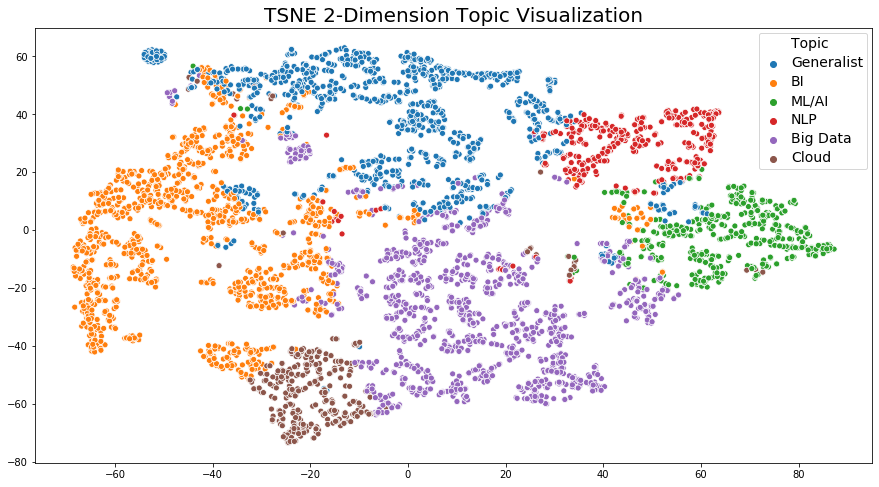

In [11]:
tsne_viz(tfidf_doc_topic,topic_df)

Using TSNE to reduce the document word matrix to two-dimensions, we see clear divisions among the different topics

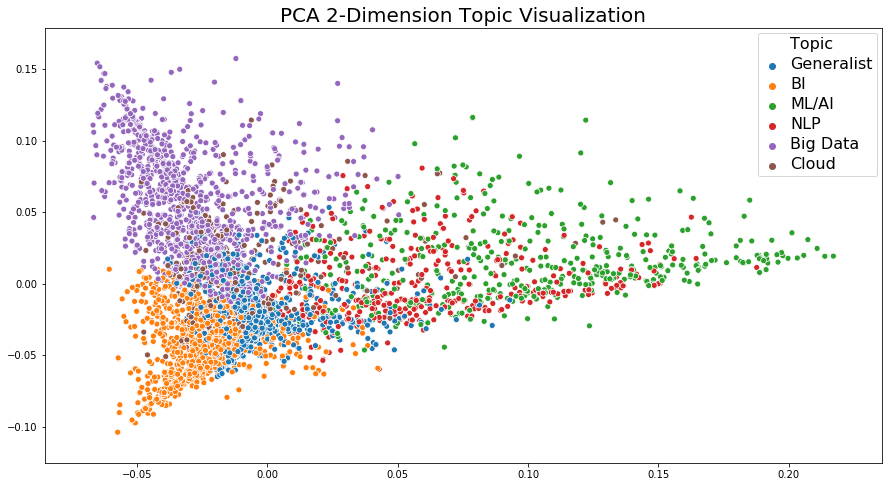

In [12]:
pca_viz(tfidf_doc_topic,topic_df)

Dimensionality reduction using PCA shows more overlap, expecially between "NLP" and "ML/AI", and the "Cloud" topic all over the map. We can deduce that "Cloud" type sills are prevalent across required different jobs.

In [13]:
new_topic_df = topic_df.copy()

In [14]:
new_topic_df.reset_index(inplace=True)

## Topic Breakdows

Text(0.5, 1.0, 'Data Science Jobs Across All Cities')

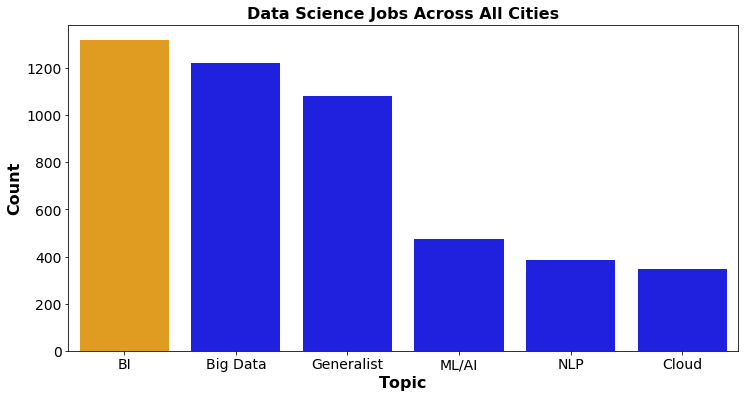

In [15]:
plt.figure(figsize=[12,6])
ax = sns.countplot(x="Topic", data=new_topic_df,order=new_topic_df.Topic.value_counts().index, palette=['orange','blue','blue','blue','blue','blue'])
plt.ylabel('Count',fontsize=16,fontweight='bold')
plt.xlabel("Topic",fontsize=16,fontweight='bold')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title ('Data Science Jobs Across All Cities',fontsize=16,fontweight='bold')

The most prevalent type of role across cities is "Business Intelligence"

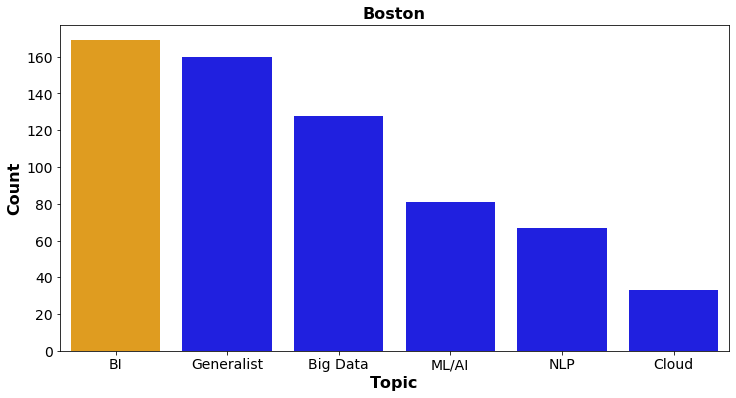

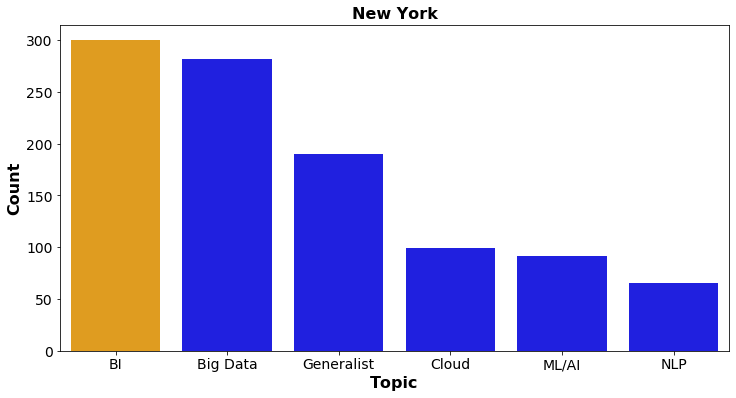

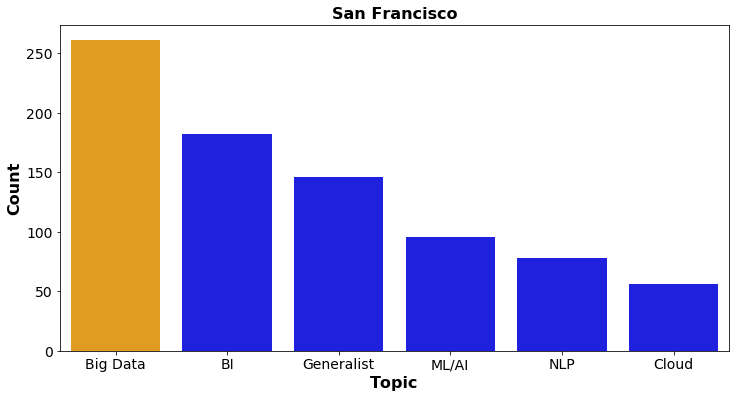

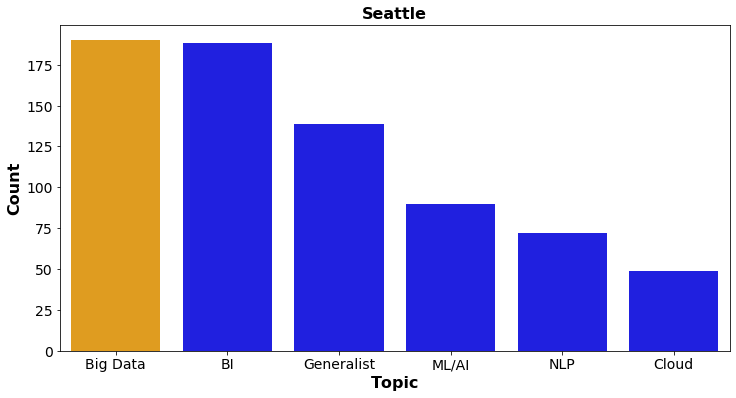

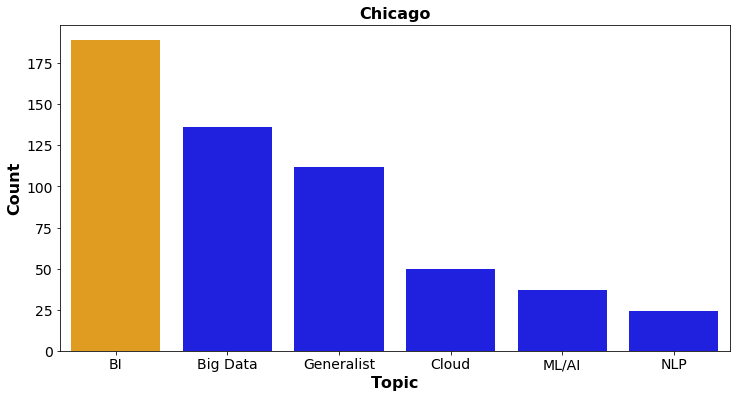

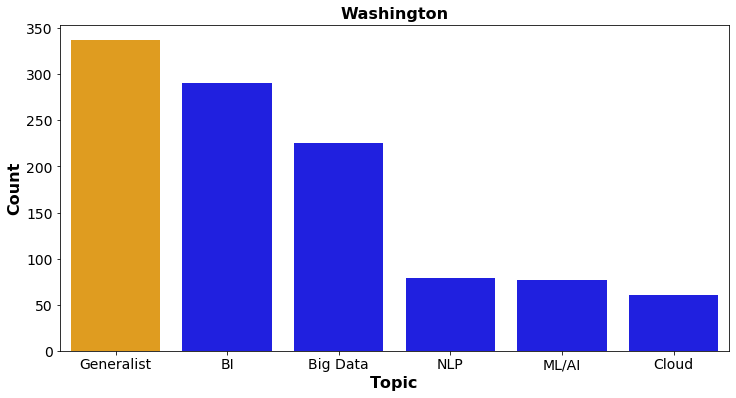

In [16]:
for i in nlp_df.city.unique():
    city_mask = (nlp_df.city==i)
    city_df = new_topic_df[city_mask]
    
    
    plt.figure(figsize=[12,6])
    ax = sns.countplot(x="Topic", data=city_df,order=city_df.Topic.value_counts().index, palette=['orange','blue','blue','blue','blue','blue'])
    plt.ylabel('Count',fontsize=16,fontweight='bold')
    plt.xlabel("Topic",fontsize=16,fontweight='bold')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.title (i,fontsize=16,fontweight='bold')
    plt.savefig(i+'.svg',type='svg')

Roles in San Francisco and Seattle tend to lean toward "Big Data" responsibilities, while Washington seems to want "Generalists"

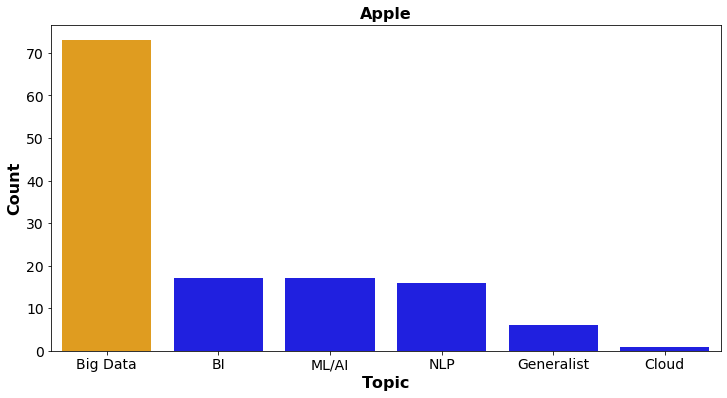

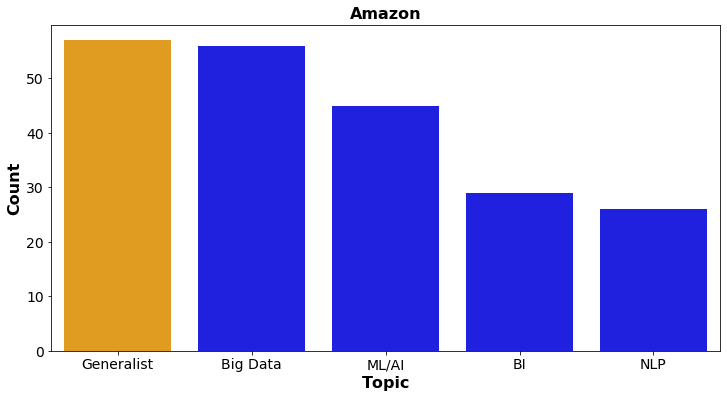

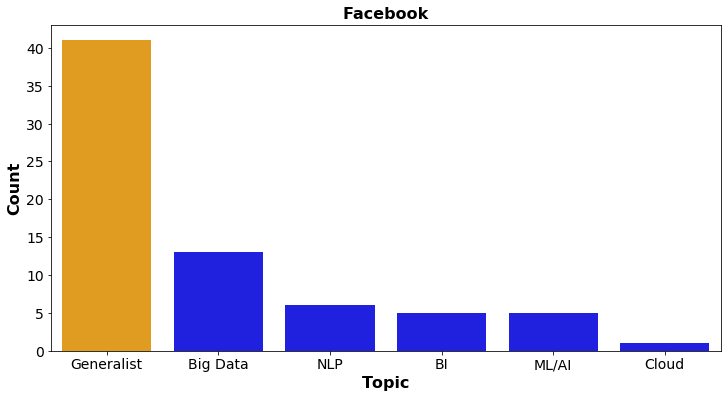

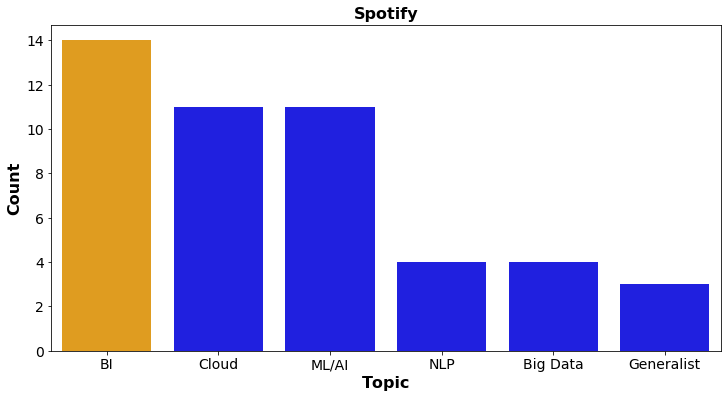

In [17]:
for i in ['Apple','Amazon','Facebook','Spotify']:
    company_mask = (nlp_df.company==i)
    company_df = new_topic_df[company_mask]
    
    
    plt.figure(figsize=[12,6])
    ax = sns.countplot(x="Topic", data=company_df,order=company_df.Topic.value_counts().index, palette=['orange','blue','blue','blue','blue','blue'])
    plt.ylabel('Count',fontsize=16,fontweight='bold')
    plt.xlabel("Topic",fontsize=16,fontweight='bold')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.title (i,fontsize=16,fontweight='bold')
    

Apple has more "Big Data Roles", while other larger tech companies are split between "Generalists" and "Business Intelligence"

## Job Recommender

Now that we have our topics, we can create recommendations using the original TFIDF document word matrix and cosine distance.

In [19]:
get_recommends(2000,tfidf_doc_topic,nlp_df,num_recom=3)

You selected : Data Engineer, Hardware Consumer Care at Google in San Francisco

You would also like: 

Partner Engineer, Machine Learning, Global Technology Partners at Google in Seattle

Sales Engineer, Data Management, Google Cloud at Google in San Francisco

GCP Data Engineer at Third Republic in New York

